<img src="https://gitlab.com/paolacaicedouis/hands_words-proyecto_vpc/-/raw/master/imgs/banner.png" alt="Banner" width="1000" height="300">


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive


In [2]:
#IMPORTS
from sklearn.externals import joblib
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage import io
import random
from skimage.color import rgb2gray
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
import tensorflow as tf
from keras import initializers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import keras

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


# Leemos las imgs y las tratamos

In [63]:
path_classes = './Datatsets/data_team/'
classes_names = ['3','A','B','faces']
print(classes_names)
array_imgs = []
array_y = []
cont = 0

for i in range(0,len(classes_names)):
  for x in (np.array(os.listdir(path_classes + classes_names[i]))):
    array_imgs = np.append(array_imgs,[ classes_names[i] + "/" + x]) #Se agrega la ruta de cada imagen a leer
        
print (array_imgs.shape) #se imprime la cantidad de rutas de las imagenes a usar

['3', 'A', 'B', 'faces']
(504,)


Se leen las imagenes, les aplicamos resize y las guardamos en ima, tambien se agregan a Y el nombre de la clase de cada imagen.

In [0]:
ima = []
Y = []
for img_path in array_imgs:
  filename = path_classes + img_path
  img =cv.cvtColor( cv.imread(path_classes+img_path) , cv.COLOR_BGR2RGB ) #leemos la imagen
  holi = cv.resize(img,(224,224)) #se le aplica resize

  ima.append(holi) #se agrega la imagen en ima
  
  if img_path.split('/')[0] == '3':
    Y.append(0)  #Se agrega la clase de la imagen en Y
  elif img_path.split('/')[0] == 'A':
    Y.append(1)  #Se agrega la clase de la imagen en Y
  elif img_path.split('/')[0] == 'B':
    Y.append(2)  #Se agrega la clase de la imagen en Y
  else:
    Y.append(3)

Apilamos los array de forma vertical.

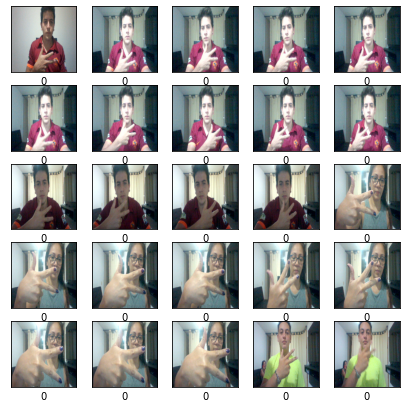

In [65]:
x = np.array(ima) #Se apila los valores de ima
y = np.array(Y) #Se apila los valores de Y

plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i],cmap='gray')
    plt.xlabel(y[i])

Imprimimos las dimensiones para asegurarnos que coincidan.

In [6]:
print(x.shape) #imprimimos las dimensiones de x
print(y.shape) #imprimimos las dimensiones de y

(504, 224, 224, 3)
(504,)


Hacemos la particion de datos.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

Imprimimos las dimensiones para asegurarnos de que coincidan.

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(453, 224, 224, 3) (453,) (51, 224, 224, 3) (51,)


Tratamos los datos

In [0]:
X_train = X_train.reshape([-1, 224, 224, 3])#Agrega un indice que exige keras (-1), 224x224, por tres canales
X_test = X_test.reshape([-1, 224, 224, 3])

X_train = X_train.astype('float32')#Lo pasamos a flotantes
X_test = X_test.astype('float32')

X_train /= 255 #Escala entre 0-1
X_test /= 255

In [10]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(453, 224, 224, 3) (453,) (51, 224, 224, 3) (51,)


# Modelo VGG16


## Importamos y entrenamos VGG16 

In [0]:
model_A = tf.keras.applications.VGG16(weights='imagenet')

553467904/553467096 [==============================] - 10s 0us/step


In [0]:
model_A.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
output = model_A.layers[-3].output
inicializador = tf.keras.initializers.lecun_uniform(seed=None)

x = tf.keras.layers.Dense(100, activation='relu')(output)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(model_A.input, x)

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
tf.keras.utils.plot_model(model, "model.png")#Imprime las capas del modelo como imagen

In [0]:
history = model.fit(X_train, y_train, epochs=1, batch_size=10,validation_data=(X_test, y_test)) #hacemos el train y test

46/46 [==============================] - 8s 184ms/step - loss: 0.0054 - accuracy: 0.9978 - val_loss: 0.4829 - val_accuracy: 0.9412


In [0]:
filename = "vgg16_99_100_tensorFlow.h5"
tf.keras.models.save_model(model,filename) #Guardamos el modelo

Tomamos una imagen para probar la red.

In [0]:
filename_foto = "/content/drive/My Drive/Datatsets/data_team_224x224x3/B/10.jpg"
img_test = cv.cvtColor(cv.resize(cv.imread(filename_foto),(224,224)),cv.COLOR_BGR2RGB)
print  (type(img_test))

<class 'numpy.ndarray'>


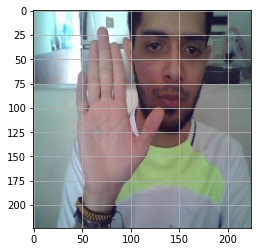

In [0]:
plt.imshow(img_test), plt.grid();

img_test = img_test.reshape([-1,224,224,3])
img_test = img_test.astype('float32')
img_test /= 255 #Se le realiza el mismo tratamiento de datos

In [0]:
print(model.predict(img_test)) #Da un porcentaje de la imagen en cada clase, donde palma es la tercera clase

[[9.6458228e-09 1.9945339e-05 9.9997950e-01 6.1887829e-07]]


## Activaciones

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
red_neural_conv1 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('block1_conv1').output)

red_neural_conv2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('block2_conv1').output)

red_neural_conv3 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('block3_conv1').output)

red_neural_conv4 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('block4_conv1').output)

In [0]:
features_conv1 = red_neural_conv1.predict(img_test)

features_conv2 = red_neural_conv2.predict(img_test)

features_conv3 = red_neural_conv3.predict(img_test)

features_conv4 = red_neural_conv4.predict(img_test)


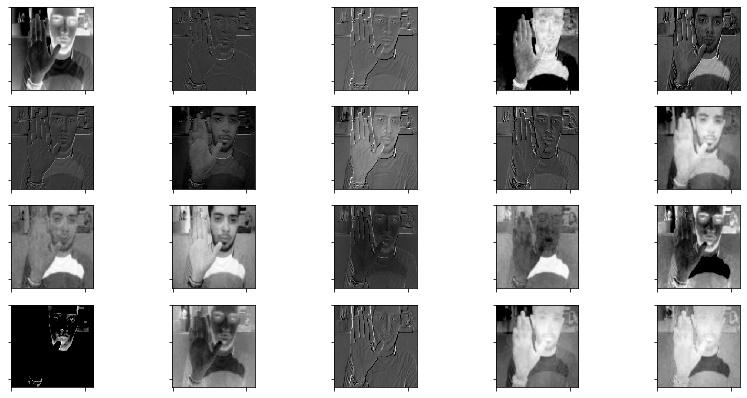

In [0]:
perm = np.random.permutation(range(features_conv1.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv1[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

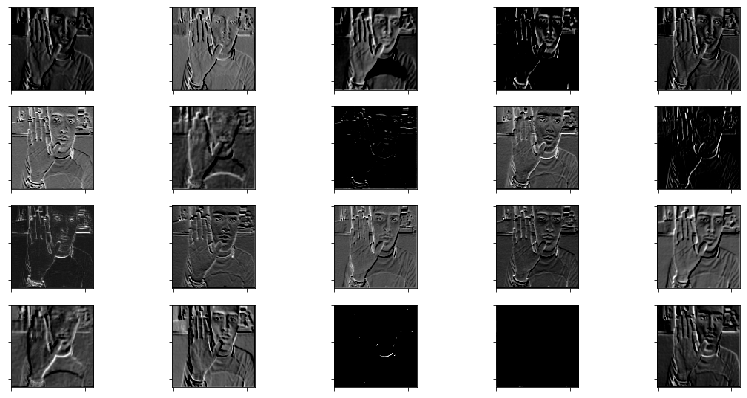

In [0]:
perm = np.random.permutation(range(features_conv2.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv2[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

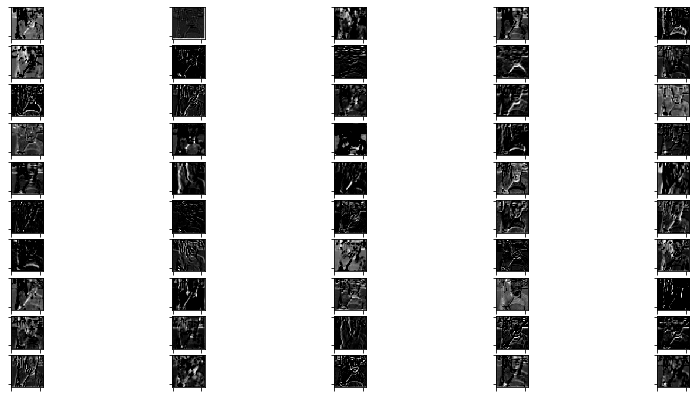

In [0]:
perm = np.random.permutation(range(features_conv3.shape[3]))[0:50]

fig = plt.figure(figsize=(14,7))
for i in range(50):
    ax=fig.add_subplot(10,5,i+1)
    plt.imshow(features_conv3[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

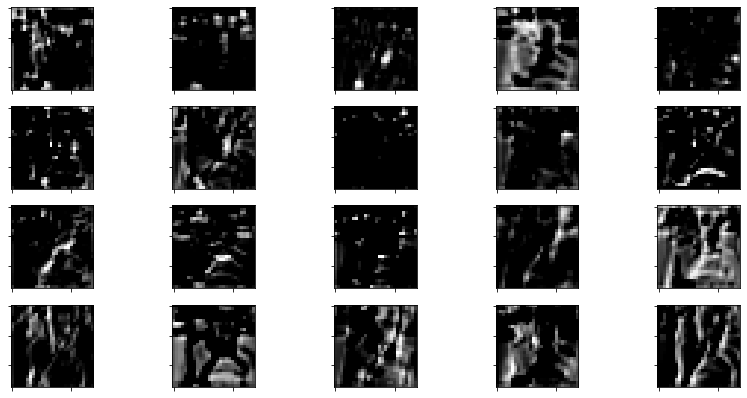

In [0]:
perm = np.random.permutation(range(features_conv4.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv4[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

64 (3, 3, 3, 64)


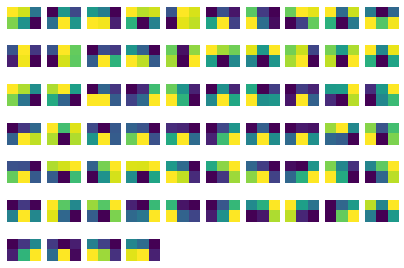

In [0]:
w = model.get_weights()[0]
plt.figure(figsize=(7,7))
w = (w-np.min(w))/(np.max(w)-np.min(w))
# print(w)
print (w.shape[-1], w.shape)
for i in range(w.shape[-1]):
    plt.subplot(10,10,i+1)
    plt.imshow(w[:-1,:,0,i])
    plt.axis("off")

# MODELO DENSENET201

In [0]:
dense =tf.keras.applications.DenseNet201(weights='imagenet')
dense.summary()
y_test = y_test.reshape([-1])

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
output = dense.layers[-3].output
inicializador = tf.keras.initializers.lecun_uniform(seed=None)

x =tf.keras.layers.MaxPooling2D(2, 2)(output)
x = tf.keras.layers.Dropout(0.2)(x)#porcentaje de neuronas q quiero q me quite 0.2 es el 20%
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='valid',name="conv4")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model =tf.keras.models.Model(dense.input,x)
print(np.shape(model.layers))

model.summary()

(714,)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________________________________________________________________

In [0]:
tf.keras.utils.plot_model(model, "dense.png")

Output hidden; open in https://colab.research.google.com to view.

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
for layer in model.layers[:168]: #201-3 neuronas
    layer.trainable = False


In [0]:
history = model.fit(X_train, y_train, epochs=10, batch_size=10,validation_data=(X_test, y_test))


Epoch 1/10
46/46 [==============================] - 9s 185ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0624 - val_accuracy: 0.9608
Epoch 2/10
46/46 [==============================] - 9s 185ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0764 - val_accuracy: 0.9608
Epoch 3/10
46/46 [==============================] - 9s 185ms/step - loss: 9.9092e-04 - accuracy: 1.0000 - val_loss: 0.1050 - val_accuracy: 0.9608
Epoch 4/10
46/46 [==============================] - 9s 185ms/step - loss: 4.1658e-04 - accuracy: 1.0000 - val_loss: 0.0917 - val_accuracy: 0.9608
Epoch 5/10
46/46 [==============================] - 8s 185ms/step - loss: 4.2397e-04 - accuracy: 1.0000 - val_loss: 0.0734 - val_accuracy: 0.9608
Epoch 6/10
46/46 [==============================] - 8s 185ms/step - loss: 6.6354e-04 - accuracy: 1.0000 - val_loss: 0.0628 - val_accuracy: 0.9608
Epoch 7/10
46/46 [==============================] - 9s 185ms/step - loss: 3.6386e-04 - accuracy: 1.0000 - val_loss: 0.0566 - val_acc

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

for layer in model.layers[:168]:
    layer.trainable = True

history = model.fit(X_train, y_train,epochs=10, batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/10
15/15 [==============================] - 17s 1s/step - loss: 0.0051 - accuracy: 0.9978 - val_loss: 0.0632 - val_accuracy: 0.9608
Epoch 2/10
15/15 [==============================] - 10s 650ms/step - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.0557 - val_accuracy: 0.9804
Epoch 3/10
15/15 [==============================] - 10s 649ms/step - loss: 0.0029 - accuracy: 0.9978 - val_loss: 0.0542 - val_accuracy: 0.9608
Epoch 4/10
15/15 [==============================] - 10s 649ms/step - loss: 0.0918 - accuracy: 0.9978 - val_loss: 0.1900 - val_accuracy: 0.9412
Epoch 5/10
15/15 [==============================] - 10s 649ms/step - loss: 0.1653 - accuracy: 0.9470 - val_loss: 3.5593 - val_accuracy: 0.3922
Epoch 6/10
15/15 [==============================] - 10s 650ms/step - loss: 0.1033 - accuracy: 0.9669 - val_loss: 6.4262 - val_accuracy: 0.4510
Epoch 7/10
15/15 [==============================] - 10s 650ms/step - loss: 0.0875 - accuracy: 0.9735 - val_loss: 1.1877 - val_accuracy: 0.7059
Ep

In [0]:
filename = "DENSE201_tensorFlow.h5"
tf.keras.models.save_model(model,filename) #Guardamos el modelo

In [0]:
filename_foto = "/content/drive/My Drive/Datatsets/data_team_224x224x3/B/10.jpg"
img_test = cv.cvtColor(cv.resize(cv.imread(filename_foto),(224,224)),cv.COLOR_BGR2RGB)
print  (type(img_test))

<class 'numpy.ndarray'>


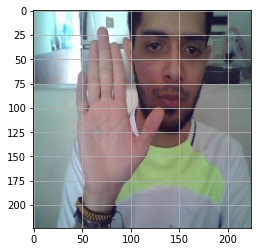

In [0]:
plt.imshow(img_test), plt.grid();

img_test = img_test.reshape([-1,224,224,3])
img_test = img_test.astype('float32')
img_test /= 255 #Se le realiza el mismo tratamiento de datos

In [0]:
print(model.predict(img_test)) #Da un porcentaje de la imagen en cada clase, donde palma es la tercera clase

[[4.3985814e-08 2.2828584e-07 9.9998009e-01 1.9671123e-05]]


ACTIVACIONES

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
red_neural_conv1 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('pool1').output)

red_neural_conv2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('conv2_block3_2_conv').output)

red_neural_conv3 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('conv2_block4_2_conv').output)

red_neural_conv4 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('pool2_bn').output)

In [0]:
features_conv1 = red_neural_conv1.predict(img_test)

features_conv2 = red_neural_conv2.predict(img_test)

features_conv3 = red_neural_conv3.predict(img_test)

features_conv4 = red_neural_conv4.predict(img_test)


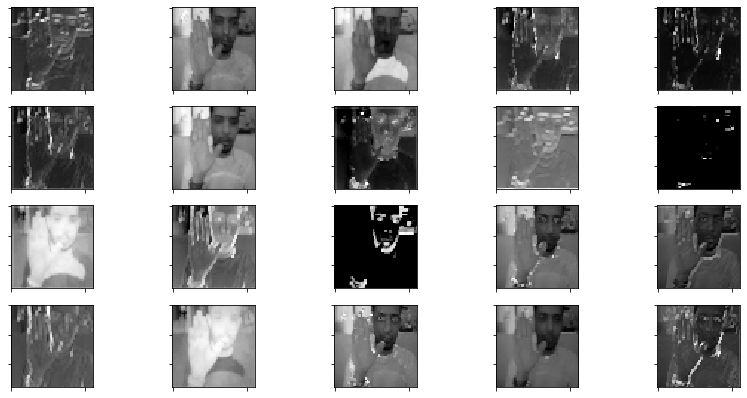

In [0]:
perm = np.random.permutation(range(features_conv1.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv1[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

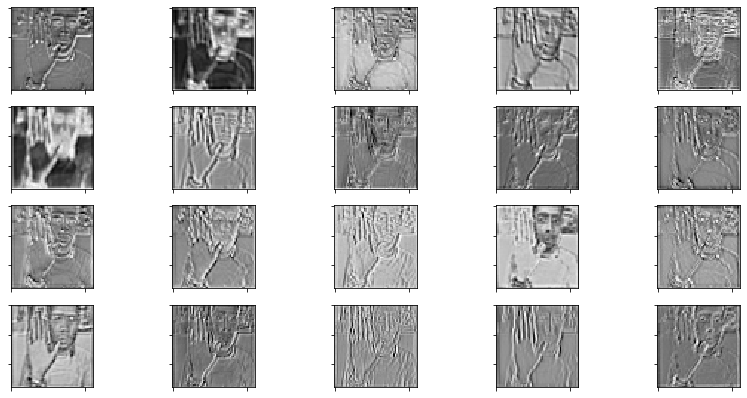

In [0]:
perm = np.random.permutation(range(features_conv2.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv2[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

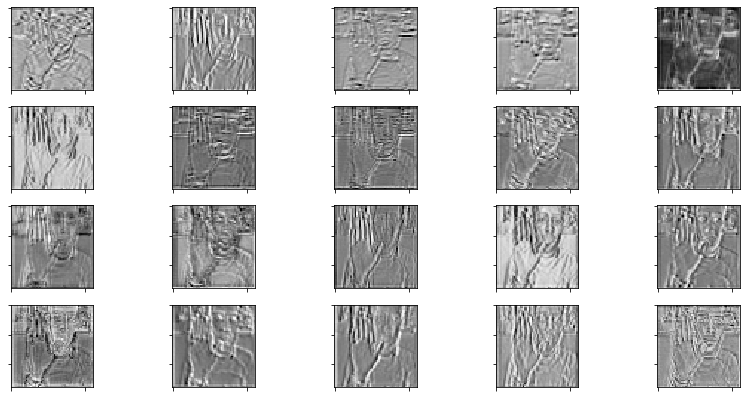

In [0]:
perm = np.random.permutation(range(features_conv3.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv3[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

64 (7, 7, 3, 64)


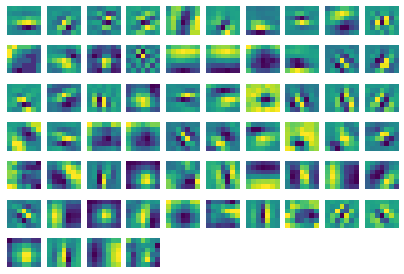

In [0]:
w = model.get_weights()[0]
plt.figure(figsize=(7,7))
w = (w-np.min(w))/(np.max(w)-np.min(w))
# print(w)
print (w.shape[-1], w.shape)
for i in range(w.shape[-1]):
    plt.subplot(10,10,i+1)
    plt.imshow(w[:-1,:,0,i])
    plt.axis("off")

# Modelo ResNet50


## Importamos y entrenamos ResNet50

In [23]:
#Aplica el categorical, para que los resultados sean mejores
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

resnet = tf.keras.applications.ResNet50(weights='imagenet')
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [42]:
output = resnet.layers[-11].output
inicializador = tf.keras.initializers.lecun_uniform(seed=None)

x = tf.keras.layers.Flatten()(output)
x = tf.keras.layers.Dense(256, kernel_initializer="glorot_normal", bias_initializer=inicializador,  activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, kernel_initializer="glorot_normal", bias_initializer=inicializador,  activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(resnet.input,x)
print(np.shape(model.layers))

model.summary()

(173,)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________________________________________________________________

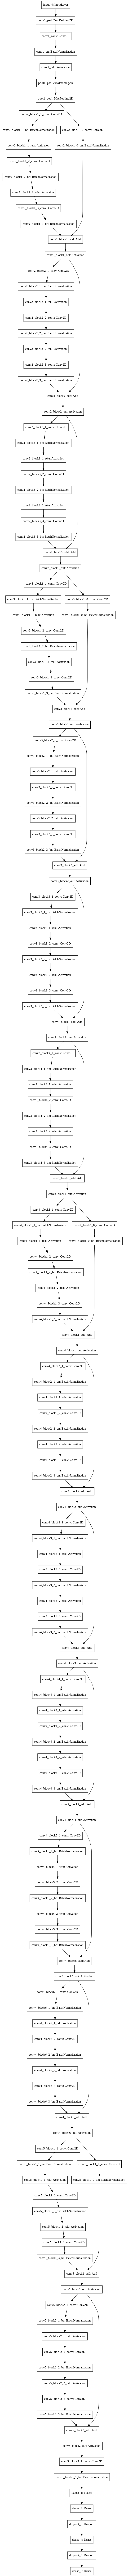

In [25]:
tf.keras.utils.plot_model(model)#Imprime las capas del modelo como imagen

In [17]:
model.layers[:-6][-1].name #Verificamos que vamos a congelar solo las capas de la resnet

'conv5_block3_1_bn'

Epoch 1/10
15/15 [==============================] - 5s 336ms/step - loss: 0.4266 - accuracy: 0.8300 - val_loss: 0.2778 - val_accuracy: 0.9020
Epoch 2/10
15/15 [==============================] - 4s 282ms/step - loss: 0.1019 - accuracy: 0.9713 - val_loss: 0.4259 - val_accuracy: 0.8235
Epoch 3/10
15/15 [==============================] - 4s 282ms/step - loss: 0.0231 - accuracy: 0.9912 - val_loss: 0.5028 - val_accuracy: 0.9216
Epoch 4/10
15/15 [==============================] - 4s 285ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.4579 - val_accuracy: 0.8235
Epoch 5/10
15/15 [==============================] - 4s 287ms/step - loss: 0.0089 - accuracy: 0.9956 - val_loss: 0.3528 - val_accuracy: 0.9020
Epoch 6/10
15/15 [==============================] - 4s 287ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3443 - val_accuracy: 0.9020
Epoch 7/10
15/15 [==============================] - 4s 284ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2671 - val_accuracy: 0.9216
Epoch 

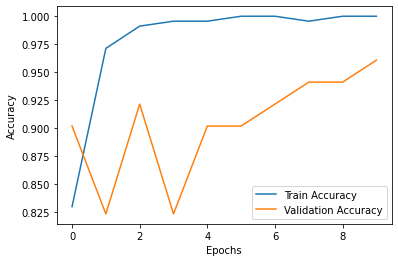

In [43]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

for layer in model.layers[:-6]:
    layer.trainable = False

history = model.fit(X_train, y_train_categorical,epochs=10, batch_size=32, validation_data=(X_test, y_test_categorical))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Epoch 1/10
15/15 [==============================] - 2s 150ms/step - loss: 0.0269 - accuracy: 0.9934 - val_loss: 0.2889 - val_accuracy: 0.9608
Epoch 2/10
15/15 [==============================] - 1s 95ms/step - loss: 0.0180 - accuracy: 0.9912 - val_loss: 0.2772 - val_accuracy: 0.9608
Epoch 3/10
15/15 [==============================] - 1s 96ms/step - loss: 0.0125 - accuracy: 0.9912 - val_loss: 0.2667 - val_accuracy: 0.9608
Epoch 4/10
15/15 [==============================] - 1s 96ms/step - loss: 0.0123 - accuracy: 0.9956 - val_loss: 0.2591 - val_accuracy: 0.9608
Epoch 5/10
15/15 [==============================] - 1s 96ms/step - loss: 0.0121 - accuracy: 0.9978 - val_loss: 0.2531 - val_accuracy: 0.9608
Epoch 6/10
15/15 [==============================] - 1s 96ms/step - loss: 0.0438 - accuracy: 0.9890 - val_loss: 0.2462 - val_accuracy: 0.9608
Epoch 7/10
15/15 [==============================] - 1s 96ms/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.2313 - val_accuracy: 0.9608
Epoch 8/10
1

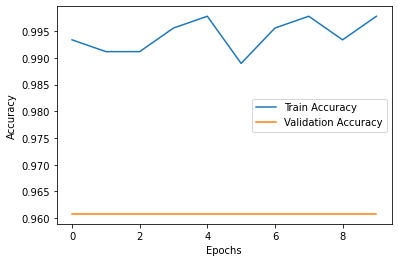

In [44]:
#Descongelamos toda la red

opt = tf.keras.optimizers.SGD(lr=0.00001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

for layer in model.layers[:-6]:
    layer.trainable = True

history = model.fit(X_train, y_train_categorical,epochs=10, batch_size=32, validation_data=(X_test, y_test_categorical))

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [0]:
filename = "resnet_99_96_tensorFlow.h5"
tf.keras.models.save_model(model,filename) #Guardamos el modelo

Tomamos una imagen para probar la red.

In [46]:
filename_foto = "./Datatsets/imagenes_de_prueba/A_img_paola.jpg"
img_test = cv.cvtColor(cv.resize(cv.imread(filename_foto),(224,224)),cv.COLOR_BGR2RGB)
print  (type(img_test))

<class 'numpy.ndarray'>


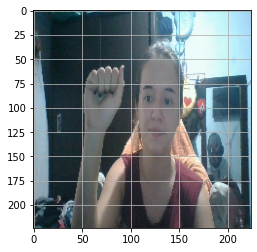

In [47]:
plt.imshow(img_test), plt.grid();

img_test = img_test.reshape([-1,224,224,3])
img_test = img_test.astype('float32')
img_test /= 255 #Se le realiza el mismo tratamiento de datos

In [48]:
print(model.predict(img_test)) #Da un porcentaje de la imagen en cada clase, donde palma es la tercera clase

[[2.7519687e-07 9.9998915e-01 1.0534681e-05 3.1842379e-08]]


## Activaciones

In [49]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
red_neural_conv1 = tf.keras.Model(inputs=model.input, 
                                          outputs=model.get_layer('conv1_relu').output)

red_neural_conv2 = tf.keras.Model(inputs=model.input, 
                                          outputs=model.get_layer('conv3_block2_2_conv').output)

red_neural_conv3 = tf.keras.Model(inputs=model.input, 
                                          outputs=model.get_layer('conv5_block3_1_bn').output)

In [0]:
features_conv1 = red_neural_conv1.predict(img_test)

features_conv2 = red_neural_conv2.predict(img_test)

features_conv3 = red_neural_conv3.predict(img_test)


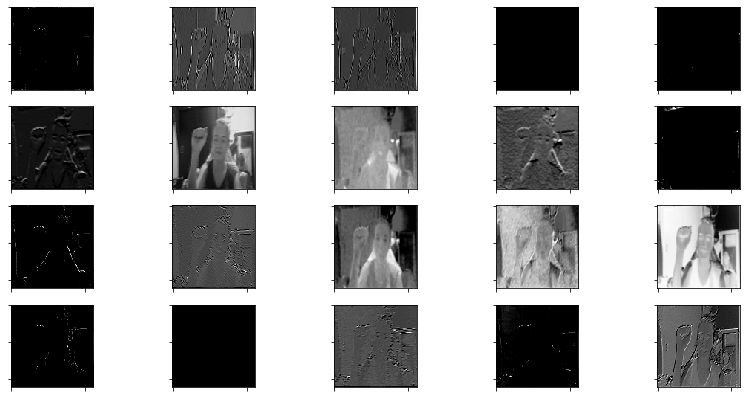

In [56]:
perm = np.random.permutation(range(features_conv1.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv1[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

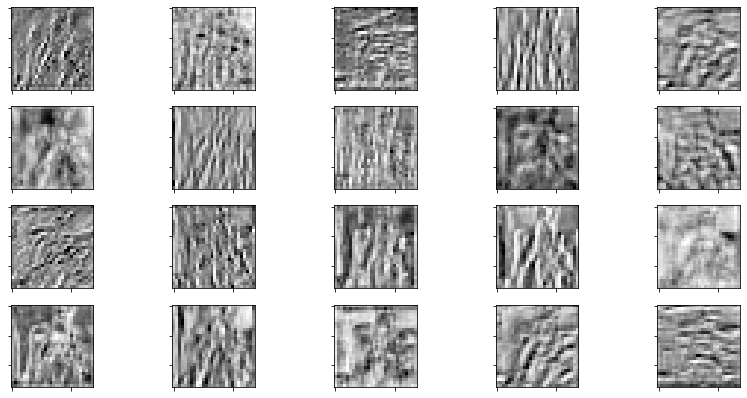

In [57]:
perm = np.random.permutation(range(features_conv2.shape[3]))[0:20]

fig = plt.figure(figsize=(14,7))
for i in range(20):
    ax=fig.add_subplot(4,5,i+1)
    plt.imshow(features_conv2[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

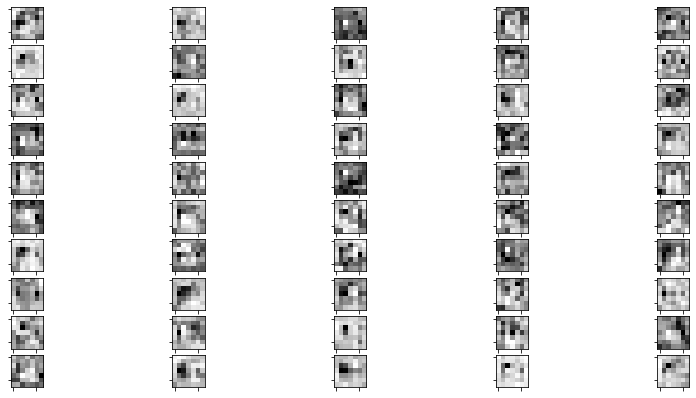

In [58]:
perm = np.random.permutation(range(features_conv3.shape[3]))[0:50]

fig = plt.figure(figsize=(14,7))
for i in range(50):
    ax=fig.add_subplot(10,5,i+1)
    plt.imshow(features_conv3[0,:,:, perm[i]], interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

64 (7, 7, 3, 64)


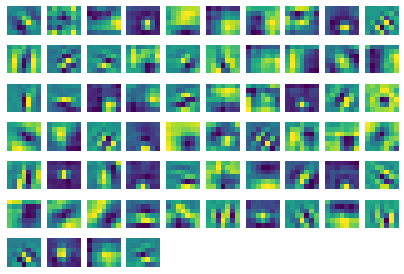

In [59]:
w = model.get_weights()[0]
plt.figure(figsize=(7,7))
w = (w-np.min(w))/(np.max(w)-np.min(w))
# print(w)
print (w.shape[-1], w.shape)
for i in range(w.shape[-1]):
    plt.subplot(10,10,i+1)
    plt.imshow(w[:-1,:,0,i])
    plt.axis("off")